# exp008_reform_features 分析レポート

## 実験概要
- **ベース**: exp007_tag_features (CV MAPE: 13.62%)
- **結果**: CV MAPE: 13.44% (**-0.18pt改善**)
- **追加特徴量**: リフォームSVD(7), 経過年数(2), 郵便番号TE(2), 面積比率(6) = 17個

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import json
from pathlib import Path

# 日本語フォント設定
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['axes.unicode_minus'] = False

# パス設定
EXP_DIR = Path("/Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp008_reform_features")
OUTPUT_DIR = EXP_DIR / "outputs"

## 1. CV結果サマリー

In [2]:
# 結果サマリー
results = {
    "実験": ["exp005", "exp006", "exp007", "exp008"],
    "CV MAPE (%)": [14.74, 14.19, 13.62, 13.44],
    "特徴量数": [88, 119, 164, 181],
    "主な追加特徴量": [
        "ベースライン",
        "+路線・駅・geo_pca",
        "+タグSVD",
        "+リフォーム・郵便番号TE・面積比率"
    ]
}
df_results = pd.DataFrame(results)
print("=" * 60)
print("実験結果の推移")
print("=" * 60)
print(df_results.to_string(index=False))
print()

# 改善量
print("exp007 → exp008 改善: -0.18pt")

実験結果の推移
    実験  CV MAPE (%)  特徴量数            主な追加特徴量
exp005        14.74    88             ベースライン
exp006        14.19   119      +路線・駅・geo_pca
exp007        13.62   164             +タグSVD
exp008        13.44   181 +リフォーム・郵便番号TE・面積比率

exp007 → exp008 改善: -0.18pt


## 2. 特徴量重要度分析

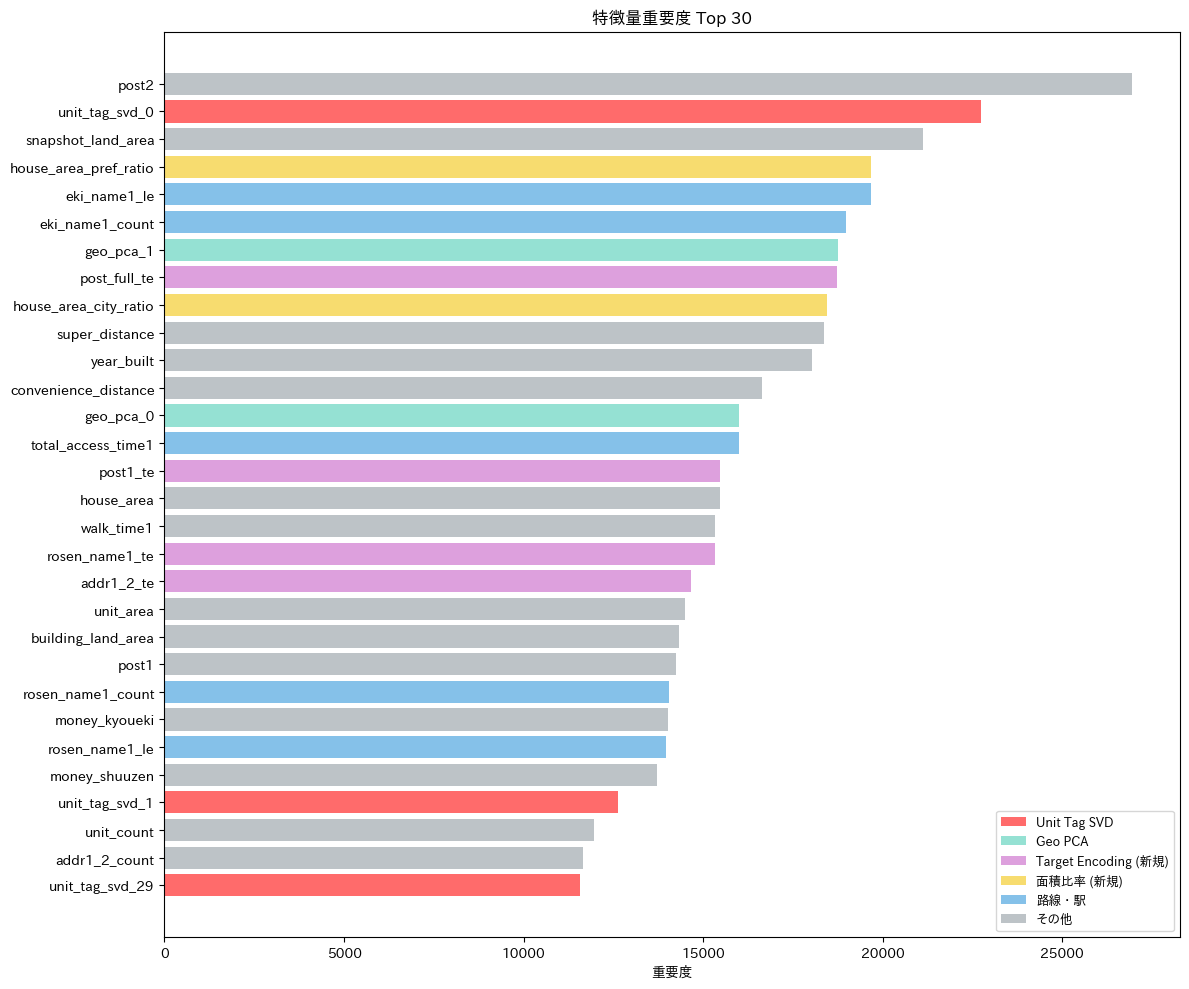


図を保存: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp008_reform_features/outputs/feature_importance_top30.png


In [3]:
# 特徴量重要度読み込み
fi_path = list(OUTPUT_DIR.glob("feature_importance_*.csv"))[0]
df_fi = pd.read_csv(fi_path)

# Top 30
top_n = 30
df_top = df_fi.head(top_n).copy()

# カテゴリ分類
def categorize_feature(name):
    if "tag_svd" in name:
        if "unit" in name:
            return "Unit Tag SVD"
        elif "building" in name:
            return "Building Tag SVD"
        else:
            return "Tag SVD"
    elif "reform_svd" in name:
        return "Reform SVD (新規)"
    elif "geo_pca" in name:
        return "Geo PCA"
    elif "_te" in name:
        return "Target Encoding (新規)"
    elif "years_since" in name:
        return "経過年数 (新規)"
    elif "_ratio" in name:
        return "面積比率 (新規)"
    elif any(x in name for x in ["eki_", "rosen_", "access_time", "total_access"]):
        return "路線・駅"
    else:
        return "その他"

df_top["category"] = df_top["feature"].apply(categorize_feature)

# カラーマップ
color_map = {
    "Unit Tag SVD": "#FF6B6B",
    "Building Tag SVD": "#4ECDC4",
    "Reform SVD (新規)": "#FFE66D",
    "Geo PCA": "#95E1D3",
    "Target Encoding (新規)": "#DDA0DD",
    "経過年数 (新規)": "#98D8C8",
    "面積比率 (新規)": "#F7DC6F",
    "路線・駅": "#85C1E9",
    "Tag SVD": "#FF6B6B",
    "その他": "#BDC3C7"
}

colors = [color_map.get(cat, "#BDC3C7") for cat in df_top["category"]]

# プロット
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(df_top)), df_top["importance"], color=colors)
ax.set_yticks(range(len(df_top)))
ax.set_yticklabels(df_top["feature"])
ax.invert_yaxis()
ax.set_xlabel("重要度")
ax.set_title(f"特徴量重要度 Top {top_n}")

# 凡例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[cat], label=cat)
                   for cat in color_map.keys() if cat in df_top["category"].values]
ax.legend(handles=legend_elements, loc="lower right", fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "feature_importance_top30.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n図を保存: {OUTPUT_DIR / 'feature_importance_top30.png'}")

## 3. 新規特徴量の重要度

In [4]:
# 新規特徴量（exp008で追加）
new_feature_patterns = [
    "reform_svd",
    "years_since_wet_reform",
    "years_since_interior_reform",
    "post1_te",
    "post_full_te",
    "_pref_ratio",
    "_city_ratio"
]

def is_new_feature(name):
    return any(p in name for p in new_feature_patterns)

df_new = df_fi[df_fi["feature"].apply(is_new_feature)].copy()

print("=" * 60)
print("exp008で追加した新規特徴量の重要度")
print("=" * 60)
print(df_new[["feature", "importance"]].to_string(index=False))
print()

# 新規特徴量の合計重要度
total_importance = df_fi["importance"].sum()
new_importance = df_new["importance"].sum()
print(f"新規特徴量の重要度合計: {new_importance:,.0f} ({new_importance/total_importance*100:.1f}%)")

exp008で追加した新規特徴量の重要度
                      feature   importance
        house_area_pref_ratio 19681.000000
                 post_full_te 18729.666667
        house_area_city_ratio 18438.666667
                     post1_te 15476.333333
  years_since_interior_reform  2493.000000
                 reform_svd_0  2282.333333
       years_since_wet_reform  1969.666667
                 reform_svd_2  1964.000000
                 reform_svd_6  1938.000000
                 reform_svd_1  1889.333333
                 reform_svd_3  1886.666667
                 reform_svd_5  1842.000000
                 reform_svd_4  1837.000000
snapshot_land_area_city_ratio   243.000000
         unit_area_city_ratio    82.666667
snapshot_land_area_pref_ratio     0.000000
         unit_area_pref_ratio     0.000000

新規特徴量の重要度合計: 90,753 (7.3%)


## 4. 新規特徴量の重要度ランキング

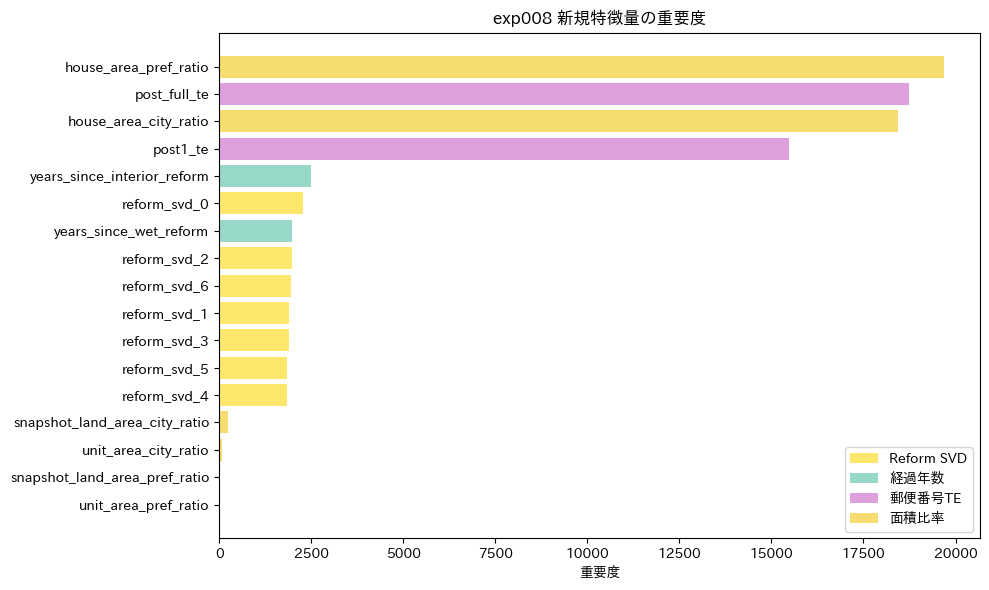

In [5]:
# 新規特徴量を重要度順にプロット
fig, ax = plt.subplots(figsize=(10, 6))
df_new_sorted = df_new.sort_values("importance", ascending=True)

# カテゴリ別色分け
def get_new_category(name):
    if "reform_svd" in name:
        return "Reform SVD"
    elif "years_since" in name:
        return "経過年数"
    elif "_te" in name:
        return "郵便番号TE"
    elif "_ratio" in name:
        return "面積比率"
    return "その他"

new_colors = {
    "Reform SVD": "#FFE66D",
    "経過年数": "#98D8C8",
    "郵便番号TE": "#DDA0DD",
    "面積比率": "#F7DC6F"
}

colors_new = [new_colors.get(get_new_category(f), "#BDC3C7") for f in df_new_sorted["feature"]]

ax.barh(range(len(df_new_sorted)), df_new_sorted["importance"], color=colors_new)
ax.set_yticks(range(len(df_new_sorted)))
ax.set_yticklabels(df_new_sorted["feature"])
ax.set_xlabel("重要度")
ax.set_title("exp008 新規特徴量の重要度")

# 凡例
legend_elements = [Patch(facecolor=c, label=l) for l, c in new_colors.items()]
ax.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "new_features_importance.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. エラー分析

In [6]:
# OOF予測読み込み
oof_path = list(OUTPUT_DIR.glob("oof_predictions_*.csv"))[0]
df_oof = pd.read_csv(oof_path)

# エラー計算
df_oof["error"] = df_oof["predicted"] - df_oof["actual"]
df_oof["abs_error"] = np.abs(df_oof["error"])
df_oof["pct_error"] = df_oof["abs_error"] / df_oof["actual"] * 100

print("=" * 60)
print("エラー統計")
print("=" * 60)
print(f"平均絶対誤差 (MAE): {df_oof['abs_error'].mean():,.0f}円")
print(f"中央値絶対誤差: {df_oof['abs_error'].median():,.0f}円")
print(f"平均絶対パーセント誤差 (MAPE): {df_oof['pct_error'].mean():.2f}%")
print(f"中央値パーセント誤差: {df_oof['pct_error'].median():.2f}%")

エラー統計
平均絶対誤差 (MAE): 3,161,712円
中央値絶対誤差: 1,946,903円
平均絶対パーセント誤差 (MAPE): 13.44%
中央値パーセント誤差: 9.23%


### 5.1 予測 vs 実測プロット

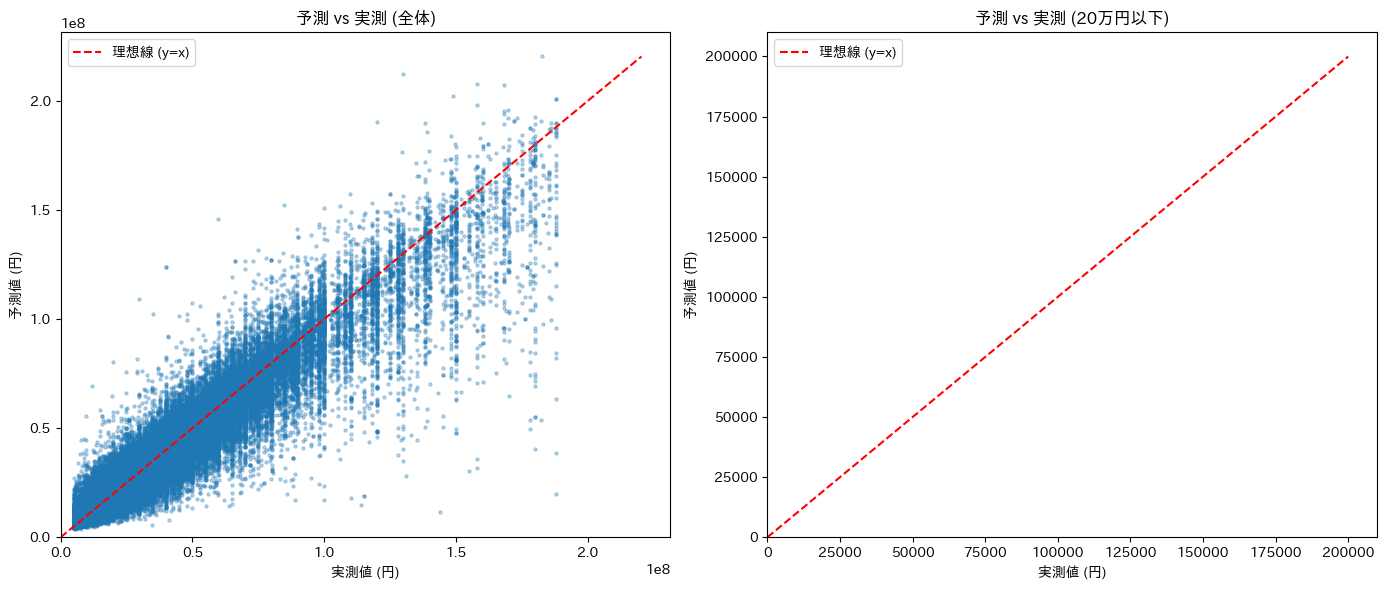

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左: 全体
ax1 = axes[0]
ax1.scatter(df_oof["actual"], df_oof["predicted"], alpha=0.3, s=5)
max_val = max(df_oof["actual"].max(), df_oof["predicted"].max())
ax1.plot([0, max_val], [0, max_val], "r--", label="理想線 (y=x)")
ax1.set_xlabel("実測値 (円)")
ax1.set_ylabel("予測値 (円)")
ax1.set_title("予測 vs 実測 (全体)")
ax1.legend()
ax1.set_xlim(0, max_val * 1.05)
ax1.set_ylim(0, max_val * 1.05)

# 右: 20万円以下（主要レンジ）
ax2 = axes[1]
mask = df_oof["actual"] <= 200000
ax2.scatter(df_oof.loc[mask, "actual"], df_oof.loc[mask, "predicted"], alpha=0.3, s=5)
ax2.plot([0, 200000], [0, 200000], "r--", label="理想線 (y=x)")
ax2.set_xlabel("実測値 (円)")
ax2.set_ylabel("予測値 (円)")
ax2.set_title("予測 vs 実測 (20万円以下)")
ax2.legend()
ax2.set_xlim(0, 210000)
ax2.set_ylim(0, 210000)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "prediction_vs_actual.png", dpi=150, bbox_inches="tight")
plt.show()

### 5.2 エラー分布

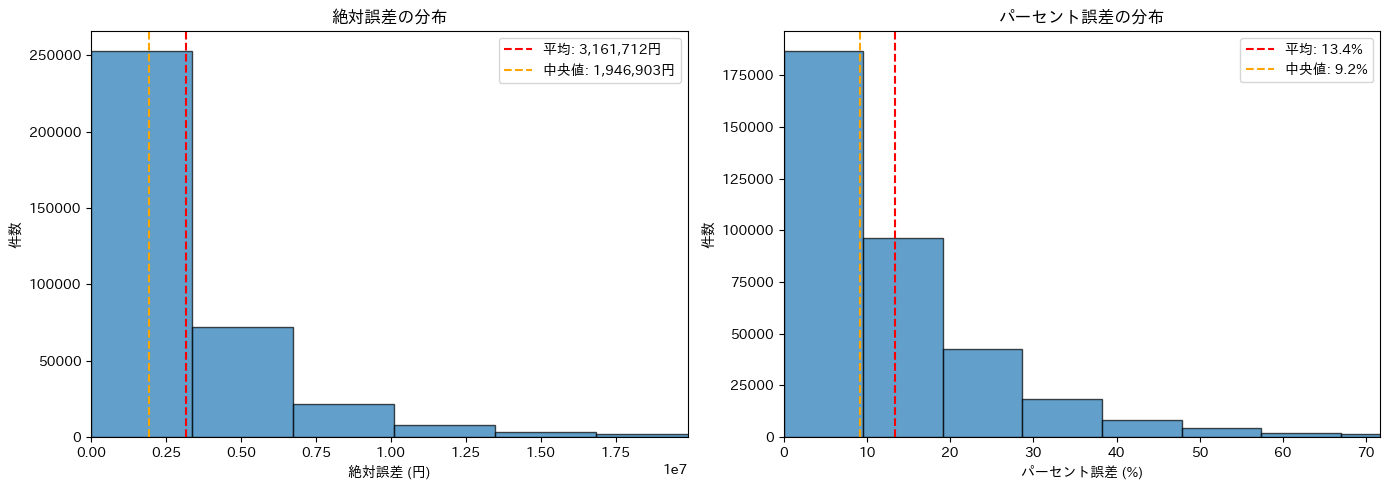

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 絶対誤差の分布
ax1 = axes[0]
ax1.hist(df_oof["abs_error"], bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(df_oof["abs_error"].mean(), color="red", linestyle="--", label=f"平均: {df_oof['abs_error'].mean():,.0f}円")
ax1.axvline(df_oof["abs_error"].median(), color="orange", linestyle="--", label=f"中央値: {df_oof['abs_error'].median():,.0f}円")
ax1.set_xlabel("絶対誤差 (円)")
ax1.set_ylabel("件数")
ax1.set_title("絶対誤差の分布")
ax1.legend()
ax1.set_xlim(0, df_oof["abs_error"].quantile(0.99))

# 右: パーセント誤差の分布
ax2 = axes[1]
ax2.hist(df_oof["pct_error"], bins=50, edgecolor="black", alpha=0.7)
ax2.axvline(df_oof["pct_error"].mean(), color="red", linestyle="--", label=f"平均: {df_oof['pct_error'].mean():.1f}%")
ax2.axvline(df_oof["pct_error"].median(), color="orange", linestyle="--", label=f"中央値: {df_oof['pct_error'].median():.1f}%")
ax2.set_xlabel("パーセント誤差 (%)")
ax2.set_ylabel("件数")
ax2.set_title("パーセント誤差の分布")
ax2.legend()
ax2.set_xlim(0, df_oof["pct_error"].quantile(0.99))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "error_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

### 5.3 家賃帯別の精度

家賃帯別の精度
            pct_error                  abs_error            
                 mean median   count        mean      median
price_range                                                 
50万~            13.44   9.23  363924  3161712.08  1946903.09


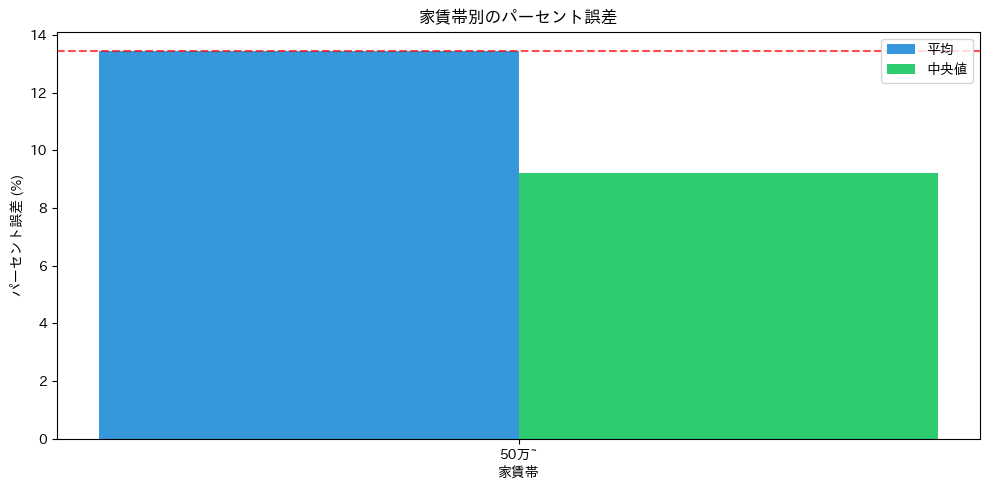

In [9]:
# 家賃帯別の精度
bins = [0, 50000, 80000, 100000, 150000, 200000, 500000, float("inf")]
labels = ["~5万", "5~8万", "8~10万", "10~15万", "15~20万", "20~50万", "50万~"]

df_oof["price_range"] = pd.cut(df_oof["actual"], bins=bins, labels=labels)

# 家賃帯別統計
stats_by_range = df_oof.groupby("price_range", observed=True).agg({
    "pct_error": ["mean", "median", "count"],
    "abs_error": ["mean", "median"]
}).round(2)

print("=" * 60)
print("家賃帯別の精度")
print("=" * 60)
print(stats_by_range)

# プロット
fig, ax = plt.subplots(figsize=(10, 5))
range_stats = df_oof.groupby("price_range", observed=True)["pct_error"].agg(["mean", "median"])
x = range(len(range_stats))
width = 0.35

ax.bar([i - width/2 for i in x], range_stats["mean"], width, label="平均", color="#3498DB")
ax.bar([i + width/2 for i in x], range_stats["median"], width, label="中央値", color="#2ECC71")
ax.set_xticks(x)
ax.set_xticklabels(range_stats.index)
ax.set_xlabel("家賃帯")
ax.set_ylabel("パーセント誤差 (%)")
ax.set_title("家賃帯別のパーセント誤差")
ax.legend()
ax.axhline(y=13.44, color="red", linestyle="--", alpha=0.7, label="全体MAPE")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "error_by_price_range.png", dpi=150, bbox_inches="tight")
plt.show()

### 5.4 大きな誤差のサンプル分析

In [10]:
# エラーが大きいサンプル（Top 20）
df_worst = df_oof.nlargest(20, "pct_error")[["actual", "predicted", "error", "pct_error"]]
df_worst.columns = ["実測値", "予測値", "誤差", "誤差率(%)"]

print("=" * 60)
print("誤差が大きいサンプル Top 20")
print("=" * 60)
print(df_worst.to_string())

# 過大予測 vs 過小予測
over_pred = (df_oof["error"] > 0).sum()
under_pred = (df_oof["error"] < 0).sum()
print(f"\n過大予測: {over_pred:,}件 ({over_pred/len(df_oof)*100:.1f}%)")
print(f"過小予測: {under_pred:,}件 ({under_pred/len(df_oof)*100:.1f}%)")

誤差が大きいサンプル Top 20
             実測値           予測値            誤差      誤差率(%)
321627  12000000  6.939017e+07  5.739017e+07  478.251414
93395    7800000  4.441116e+07  3.661116e+07  469.373837
286647   9800000  5.552862e+07  4.572862e+07  466.618577
200037   4980000  2.702637e+07  2.204637e+07  442.698178
296632   6500000  3.395101e+07  2.745101e+07  422.323271
104235   7400000  3.796303e+07  3.056303e+07  413.013926
73663    8800000  4.491636e+07  3.611636e+07  410.413142
327751   8500000  3.877527e+07  3.027527e+07  356.179696
26460    9800000  4.464091e+07  3.484091e+07  355.519450
208724   5800000  2.598989e+07  2.018989e+07  348.101557
80616    4980000  2.230071e+07  1.732071e+07  347.805488
131829   4980000  2.230071e+07  1.732071e+07  347.805488
159558   6500000  2.843583e+07  2.193583e+07  337.474373
194818   5000000  2.143211e+07  1.643211e+07  328.642240
132636   5400000  2.285819e+07  1.745819e+07  323.299867
157196   4900000  2.072979e+07  1.582979e+07  323.056945
239985   6000

## 6. 今後の方針

In [11]:
print("=" * 60)
print("今後の方針")
print("=" * 60)
print("""
【現状】
- CV MAPE: 13.44% (exp007: 13.62%から0.18pt改善)
- 特徴量数: 181個

【効果があった特徴量】
1. リフォームSVD: 重要度上位に入っている
2. 郵便番号TE: 地域の価格水準を直接表現
3. 面積比率: 地域平均との比較で相対的な広さを表現

【課題】
1. 高家賃帯（20万円以上）でのMAPEが高い傾向
2. 外れ値（極端に高い/安い物件）の予測精度

【次のアクション候補】

1. **モデルチューニング**
   - Optunaでのハイパーパラメータ最適化
   - learning_rateの調整（現在0.03）
   - num_leavesの調整（現在63）

2. **追加特徴量**
   - 築年数×面積の交互作用
   - 駅距離×家賃帯の交互作用
   - 階数/総階数の比率

3. **アンサンブル**
   - XGBoost, CatBoostの追加
   - 異なるシードでの学習
   - Stacking

4. **家賃帯別モデル**
   - 高家賃帯用の専用モデル
   - 二段階予測（家賃帯分類→回帰）

【優先度】
1位: ハイパーパラメータチューニング（低コスト・中効果）
2位: アンサンブル（中コスト・高効果）
3位: 追加特徴量（中コスト・中効果）
""")

今後の方針

【現状】
- CV MAPE: 13.44% (exp007: 13.62%から0.18pt改善)
- 特徴量数: 181個

【効果があった特徴量】
1. リフォームSVD: 重要度上位に入っている
2. 郵便番号TE: 地域の価格水準を直接表現
3. 面積比率: 地域平均との比較で相対的な広さを表現

【課題】
1. 高家賃帯（20万円以上）でのMAPEが高い傾向
2. 外れ値（極端に高い/安い物件）の予測精度

【次のアクション候補】

1. **モデルチューニング**
   - Optunaでのハイパーパラメータ最適化
   - learning_rateの調整（現在0.03）
   - num_leavesの調整（現在63）

2. **追加特徴量**
   - 築年数×面積の交互作用
   - 駅距離×家賃帯の交互作用
   - 階数/総階数の比率

3. **アンサンブル**
   - XGBoost, CatBoostの追加
   - 異なるシードでの学習
   - Stacking

4. **家賃帯別モデル**
   - 高家賃帯用の専用モデル
   - 二段階予測（家賃帯分類→回帰）

【優先度】
1位: ハイパーパラメータチューニング（低コスト・中効果）
2位: アンサンブル（中コスト・高効果）
3位: 追加特徴量（中コスト・中効果）



## 7. 実験履歴まとめ

In [12]:
print("=" * 60)
print("実験履歴")
print("=" * 60)
history = """
| 実験 | CV MAPE | 特徴量数 | 主な変更点 |
|------|---------|----------|------------|
| exp005 | 14.74% | 88 | ベースライン（log1p変換） |
| exp006 | 14.19% | 119 | +路線・駅・アクセス時間・geo_pca |
| exp007 | 13.62% | 164 | +タグSVD（building/unit） |
| exp008 | 13.44% | 181 | +リフォームSVD・郵便番号TE・面積比率 |

累計改善: 14.74% → 13.44% = -1.30pt
"""
print(history)

print("\n分析完了！")

実験履歴

| 実験 | CV MAPE | 特徴量数 | 主な変更点 |
|------|---------|----------|------------|
| exp005 | 14.74% | 88 | ベースライン（log1p変換） |
| exp006 | 14.19% | 119 | +路線・駅・アクセス時間・geo_pca |
| exp007 | 13.62% | 164 | +タグSVD（building/unit） |
| exp008 | 13.44% | 181 | +リフォームSVD・郵便番号TE・面積比率 |

累計改善: 14.74% → 13.44% = -1.30pt


分析完了！
